## Аттестационное задание. Прогнозирование конечных свойств новых материалов (композиционных материалов)

#### Импорты

In [1]:
# выполняю импорты необходимых библиотек
import pandas as pd
import numpy as np
import wget
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

import smogn

from sklearn import svm
from sklearn import tree
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


import tensorflow as tf
from tensorflow import keras
from keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

#### Загрузка данных

In [5]:
# загружаю датасет со свойствами композитов, объединение по индексу, тип объединения - INNER
url = 'https://drive.usercontent.google.com/u/0/uc?id=1B1s5gBlvgU81H9GGolLQVw_SOi-vyNf2&export=download'
zip_file =  ZipFile(wget.download(url))
zip_file.extractall('./dataset')

!ls -lh ./dataset

100% [........................................................] 177906 / 177906total 472
-rw-r--r--  1 akremenetskaya  staff   136K 10 мар 21:05 X_bp.xlsx
-rw-r--r--  1 akremenetskaya  staff    41K 10 мар 21:05 X_nup.xlsx


In [2]:
data_1 = pd.read_excel('./dataset/X_bp.xlsx', index_col=0)
data_2 = pd.read_excel('./dataset/X_nup.xlsx', index_col=0)

dataset = data_1.join(data_2, how='inner')

### EDA - Exploratory Data Analysis

In [3]:
# вывожу случайные 5 строк датасета, чтобы посмотреть на данные
dataset.sample(5)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
374,3.950501,1910.632051,700.907095,152.821434,22.333254,235.940152,143.030854,68.830496,2434.857214,265.837278,0,5.907932,55.948455
784,2.815082,1886.864085,1157.430119,113.336615,19.444788,346.604427,109.292979,76.918789,2717.988811,275.680811,90,4.331443,71.673397
380,1.988732,2008.300311,866.596263,82.558627,26.647004,274.563206,342.540268,78.202731,2407.873386,235.171423,0,8.465672,50.636439
313,4.107086,1989.461473,678.579157,98.431047,20.888454,294.194381,444.498714,71.949778,1944.712515,263.523445,0,7.401052,66.918583
404,3.563509,1861.493546,815.993641,134.855988,23.340665,227.332974,153.853595,79.916185,3089.128812,343.515980,0,3.570410,64.040965


#### Data Quality

In [4]:
# изучаю состав данных
# делаю выводы, что пропущенных значений нет, данные в основном в формате числе с плавающей запятой,
# за исключением колонки "Угол нашивки" - целое
# пропущенных значений нет
# все колонки кроме "Угол нашивки" имеют большое кол-во уникальных значений
# Угол нашивки имеет только два значения - 0 и 90

dataset_info = pd.DataFrame({
    "Data type": dataset.dtypes,
    "Missing values": dataset.isnull().sum(),
    "Unique values": dataset.nunique()
}).sort_values(by="Unique values", ascending=False)
dataset_info

,Data type,Missing values,Unique values
"модуль упругости, ГПа",float64,0,1020
Соотношение матрица-наполнитель,float64,0,1014
"Плотность, кг/м3",float64,0,1013
"Количество отвердителя, м.%",float64,0,1005
"Содержание эпоксидных групп,%_2",float64,0,1004
"Поверхностная плотность, г/м2",float64,0,1004
"Модуль упругости при растяжении, ГПа",float64,0,1004
"Прочность при растяжении, МПа",float64,0,1004
"Температура вспышки, С_2",float64,0,1003
"Потребление смолы, г/м2",float64,0,1003


In [5]:
# изучаю характеристики данных
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0,2.930366,0.913222,0.389403,2.317887,2.906878,3.552660,5.591742
"Плотность, кг/м3",1023.0,1975.734888,73.729231,1731.764635,1924.155467,1977.621657,2021.374375,2207.773481
"модуль упругости, ГПа",1023.0,739.923233,330.231581,2.436909,500.047452,739.664328,961.812526,1911.536477
"Количество отвердителя, м.%",1023.0,110.570769,28.295911,17.740275,92.443497,110.564840,129.730366,198.953207
"Содержание эпоксидных групп,%_2",1023.0,22.244390,2.406301,14.254985,20.608034,22.230744,23.961934,33.000000
"Температура вспышки, С_2",1023.0,285.882151,40.943260,100.000000,259.066528,285.896812,313.002106,413.273418
"Поверхностная плотность, г/м2",1023.0,482.731833,281.314690,0.603740,266.816645,451.864365,693.225017,1399.542362
"Модуль упругости при растяжении, ГПа",1023.0,73.328571,3.118983,64.054061,71.245018,73.268805,75.356612,82.682051
"Прочность при растяжении, МПа",1023.0,2466.922843,485.628006,1036.856605,2135.850448,2459.524526,2767.193119,3848.436732
"Потребление смолы, г/м2",1023.0,218.423144,59.735931,33.803026,179.627520,219.198882,257.481724,414.590628


### Отсутствующие значения

In [6]:
total_fields = dataset.size
missing_values_count = dataset.isnull().sum().sum()

# считаю процент пропущенных значений
missing_values_percentage = (missing_values_count / total_fields) * 100
print(f"Процент отсутствующих значений: {missing_values_percentage:.2f}%")

Процент отсутствующих значений: 0.00%


### Выбросы

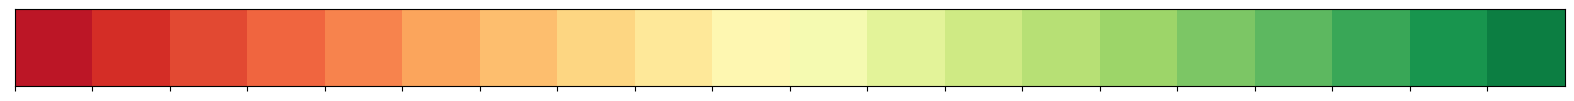

In [2]:
selected_palette = sns.color_palette("RdYlGn", n_colors=20)

sns.palplot(selected_palette)
plt.show()

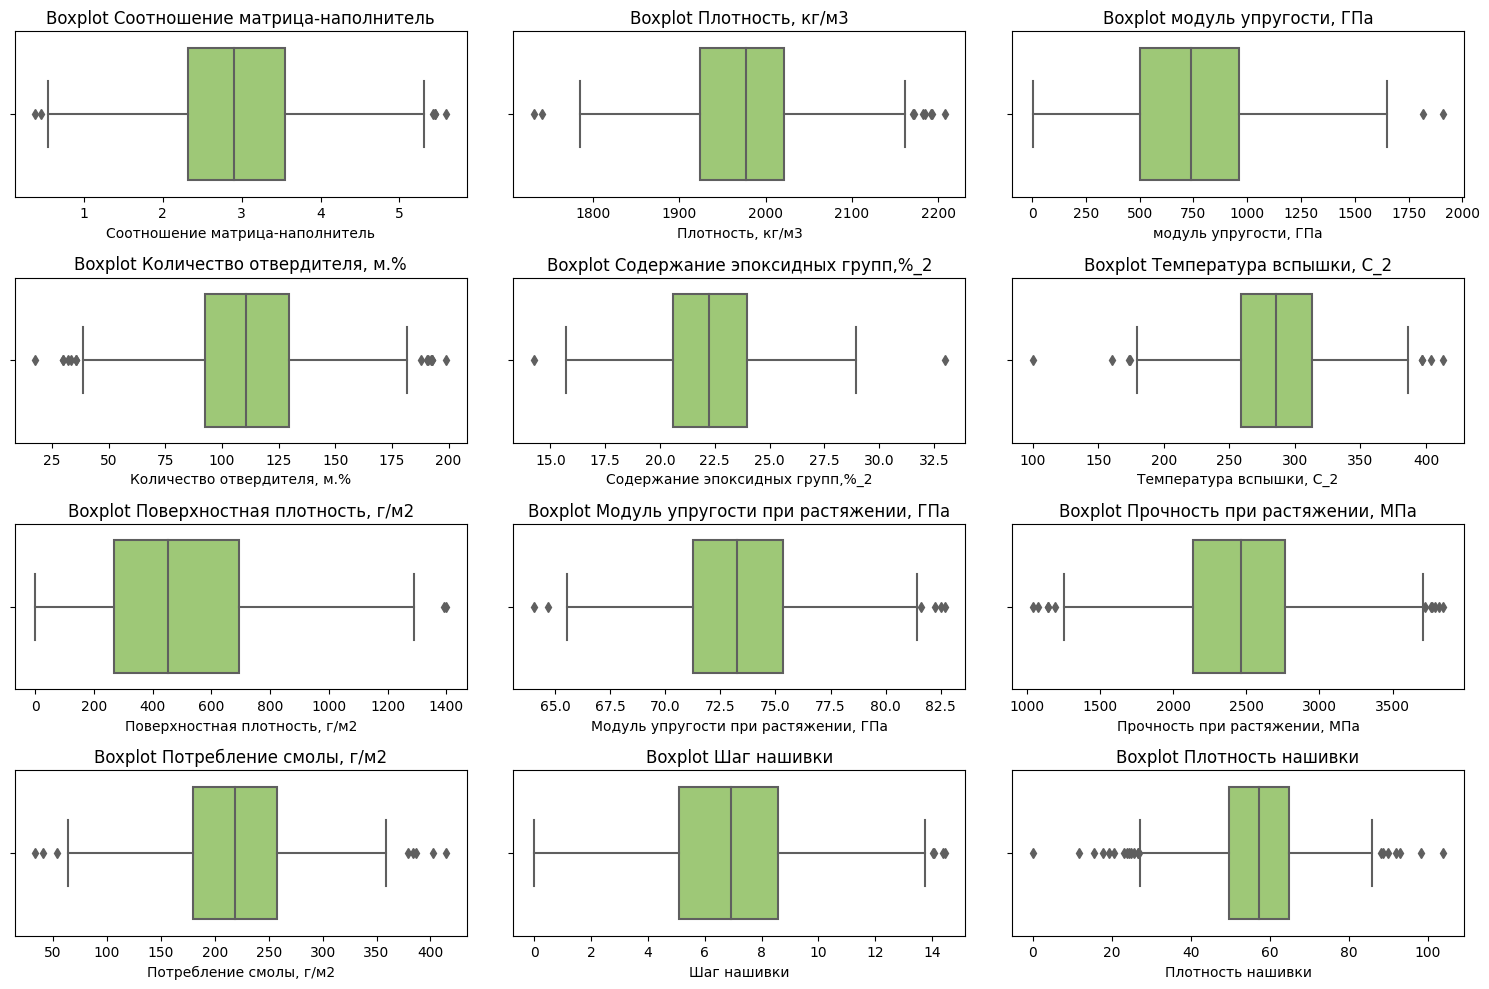

In [8]:
# Создание полотна с подгруппами для боксплотов
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))  # Измените размер figsize по вашему желанию

# Разворачиваем матрицу графиков и перебираем столбцы
# Убираю столбец с Углом нашивки, так как там всего два уникальных значения и нет выбросов
for ax, column in zip(axes.flat, dataset.drop('Угол нашивки, град', axis=1).columns):
    fig.tight_layout()
    sns.boxplot(x=dataset[column], ax=ax, color=selected_palette[14])
    ax.set_title(f"Boxplot {column}")

plt.show()

In [9]:
# расчитываю долю выбросов среди данных за исключением признака Угол нашивки, так считаю его категориальным
outlier_results = []

dataset_out = dataset.drop('Угол нашивки, град', axis=1)

for column in dataset_out:
    Q1 = dataset_out[column].quantile(0.25)
    Q3 = dataset_out[column].quantile(0.75)
    
    IQR = Q3 - Q1
    
    # Левый ус: минимум между расчетной границей и фактическим минимальным значением
    lower_bound = max(dataset_out[column].min(), Q1 - 1.5 * IQR)
    
    # Правый ус: максимум между расчетной границей и фактическим максимальным значением
    upper_bound = min(dataset_out[column].max(), Q3 + 1.5 * IQR)
    
    dataset_out_no_outliers = dataset_out[(dataset_out[column] >= lower_bound) & (dataset_out[column] <= upper_bound)]
    
    outlier_ratio = round(((len(dataset_out) - len(dataset_out_no_outliers)) / len(dataset_out) * 100), 2)
    
    outlier_results.append({'Column': column, 'Outlier Ratio': outlier_ratio})
    dataset_out[f'{column}_box_plot_outlier'] = ((dataset_out[column] < lower_bound) | (dataset_out[column] > upper_bound)).astype(int)

outlier_results_df = pd.DataFrame(outlier_results)
outlier_results_df

,Column,Outlier Ratio
0,Соотношение матрица-наполнитель,0.59
1,"Плотность, кг/м3",0.88
2,"модуль упругости, ГПа",0.20
3,"Количество отвердителя, м.%",1.37
4,"Содержание эпоксидных групп,%_2",0.20
5,"Температура вспышки, С_2",0.78
6,"Поверхностная плотность, г/м2",0.20
7,"Модуль упругости при растяжении, ГПа",0.59
8,"Прочность при растяжении, МПа",1.08
9,"Потребление смолы, г/м2",0.78


In [11]:
outliers_count = []
for column in dataset_out.columns:
    if "box_plot_outlier" in column:
        outliers_count.append({'Column': column, 'Outlier Count': dataset_out[f'{column}'].sum()})
outliers_count = pd.DataFrame(outliers_count)
outliers_count

,Column,Outlier Count
0,Соотношение матрица-наполнитель_box_plot_outlier,6
1,"Плотность, кг/м3_box_plot_outlier",9
2,"модуль упругости, ГПа_box_plot_outlier",2
3,"Количество отвердителя, м.%_box_plot_outlier",14
4,"Содержание эпоксидных групп,%_2_box_plot_outlier",2
5,"Температура вспышки, С_2_box_plot_outlier",8
6,"Поверхностная плотность, г/м2_box_plot_outlier",2
7,"Модуль упругости при растяжении, ГПа_box_plot_...",6
8,"Прочность при растяжении, МПа_box_plot_outlier",11
9,"Потребление смолы, г/м2_box_plot_outlier",8


In [12]:
# процентное соотношение выбросов ко всему датасету
all_outliers_ratio = (outliers_count['Outlier Count'].sum() / dataset.drop('Угол нашивки, град', axis=1).count().sum()) * 100
print(f'Процент выбросов от всего датасета: {all_outliers_ratio:.2f}%')

Процент выбросов от всего датасета: 0.76%


In [13]:
# общая сумма выбросов
outliers_count['Outlier Count'].sum()

93

#### Распределение

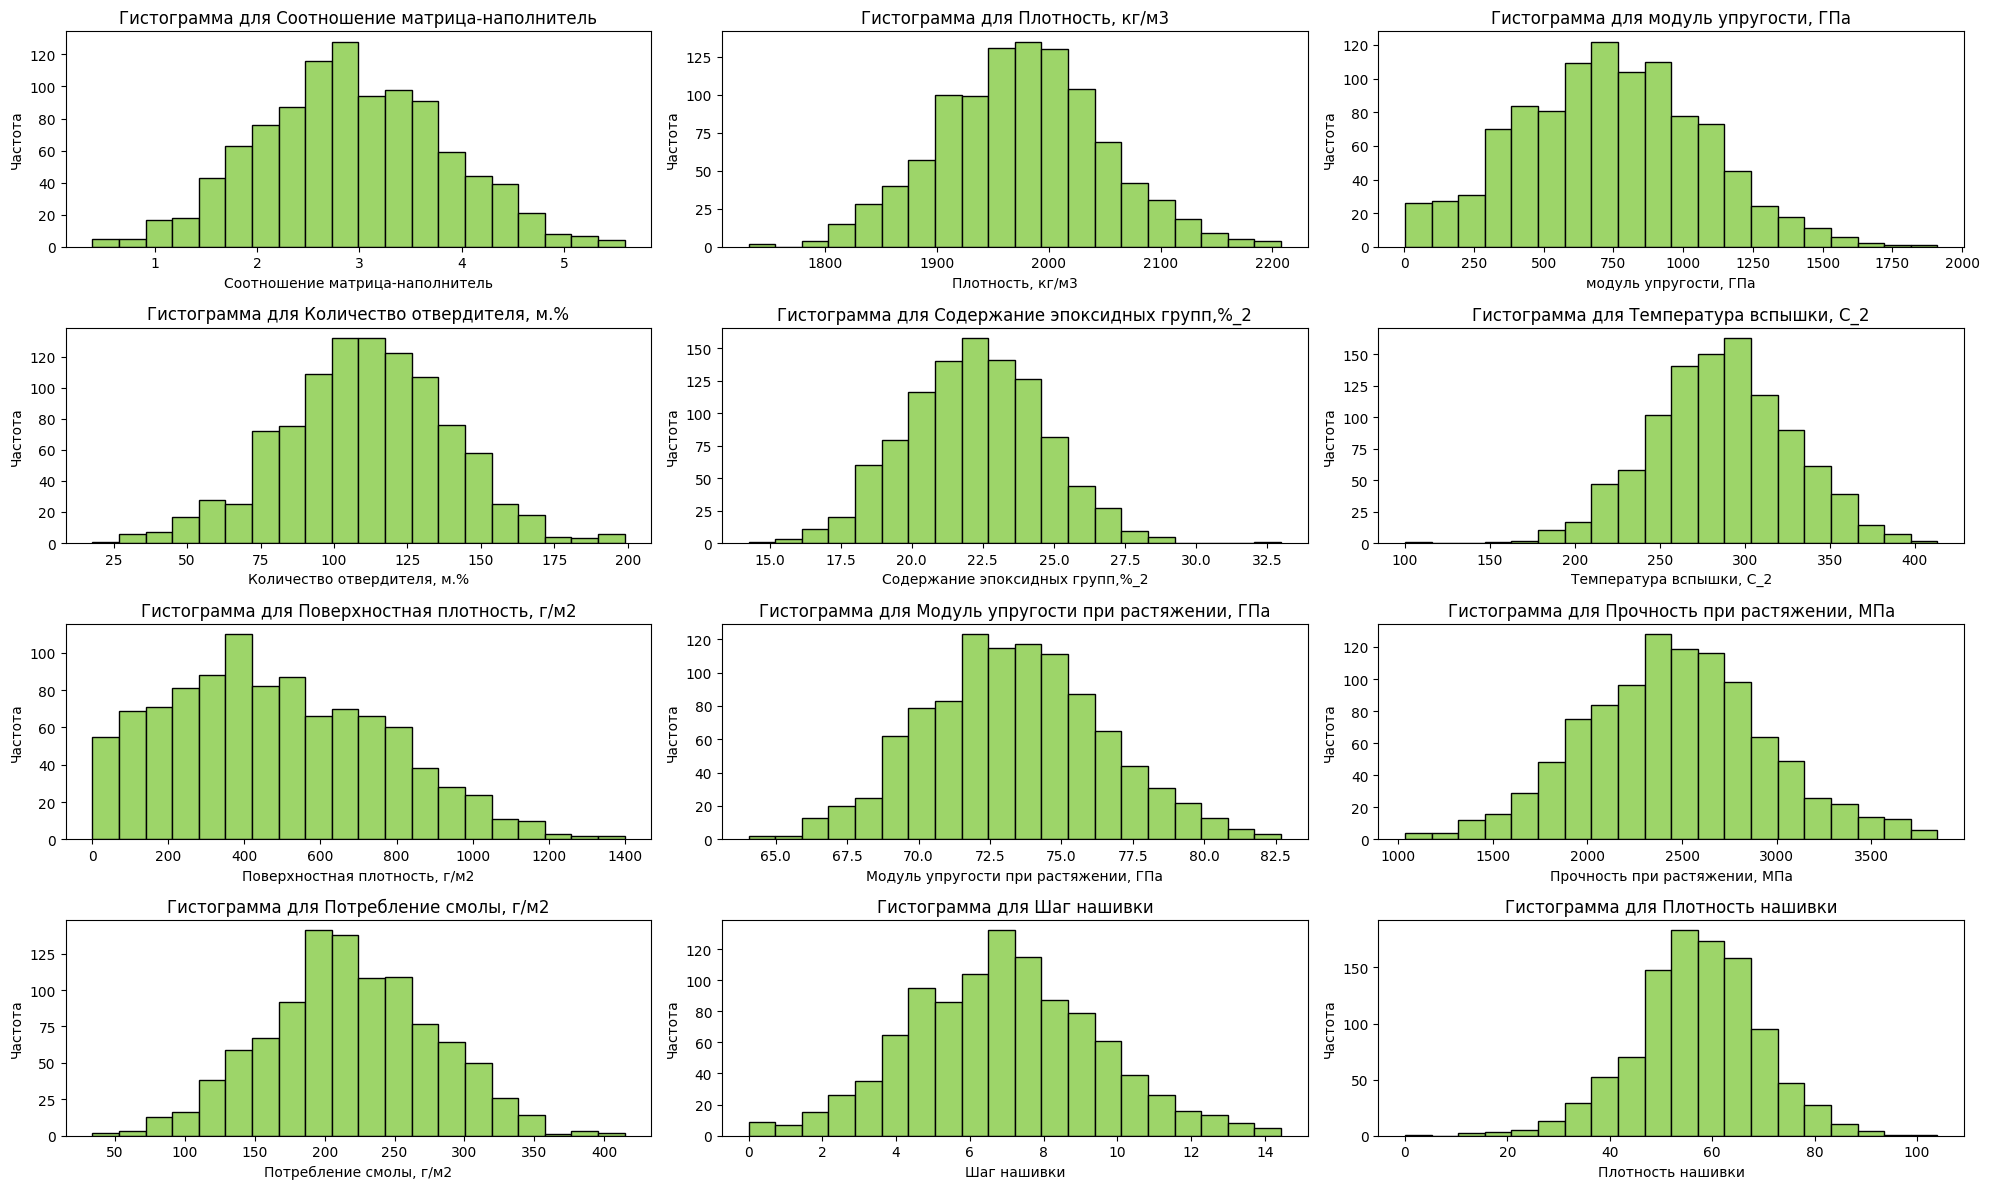

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 12))
flattened_axes = axes.flatten()

# Проходим по каждому столбцу из numeric_variables и создаем гистограмму
for i, column in enumerate(dataset.drop('Угол нашивки, град', axis=1).columns):
    flattened_axes[i].hist(dataset[column], bins=20, color=selected_palette[14], edgecolor='black')
    flattened_axes[i].set_title(f"Гистограмма для {column}")
    flattened_axes[i].set_xlabel(column)
    flattened_axes[i].set_ylabel("Частота")

# Отключаем неиспользуемые оси
for j in range(len(dataset.drop('Угол нашивки, град', axis=1).columns), len(flattened_axes)):
    flattened_axes[j].axis('off')

plt.tight_layout()
plt.show()

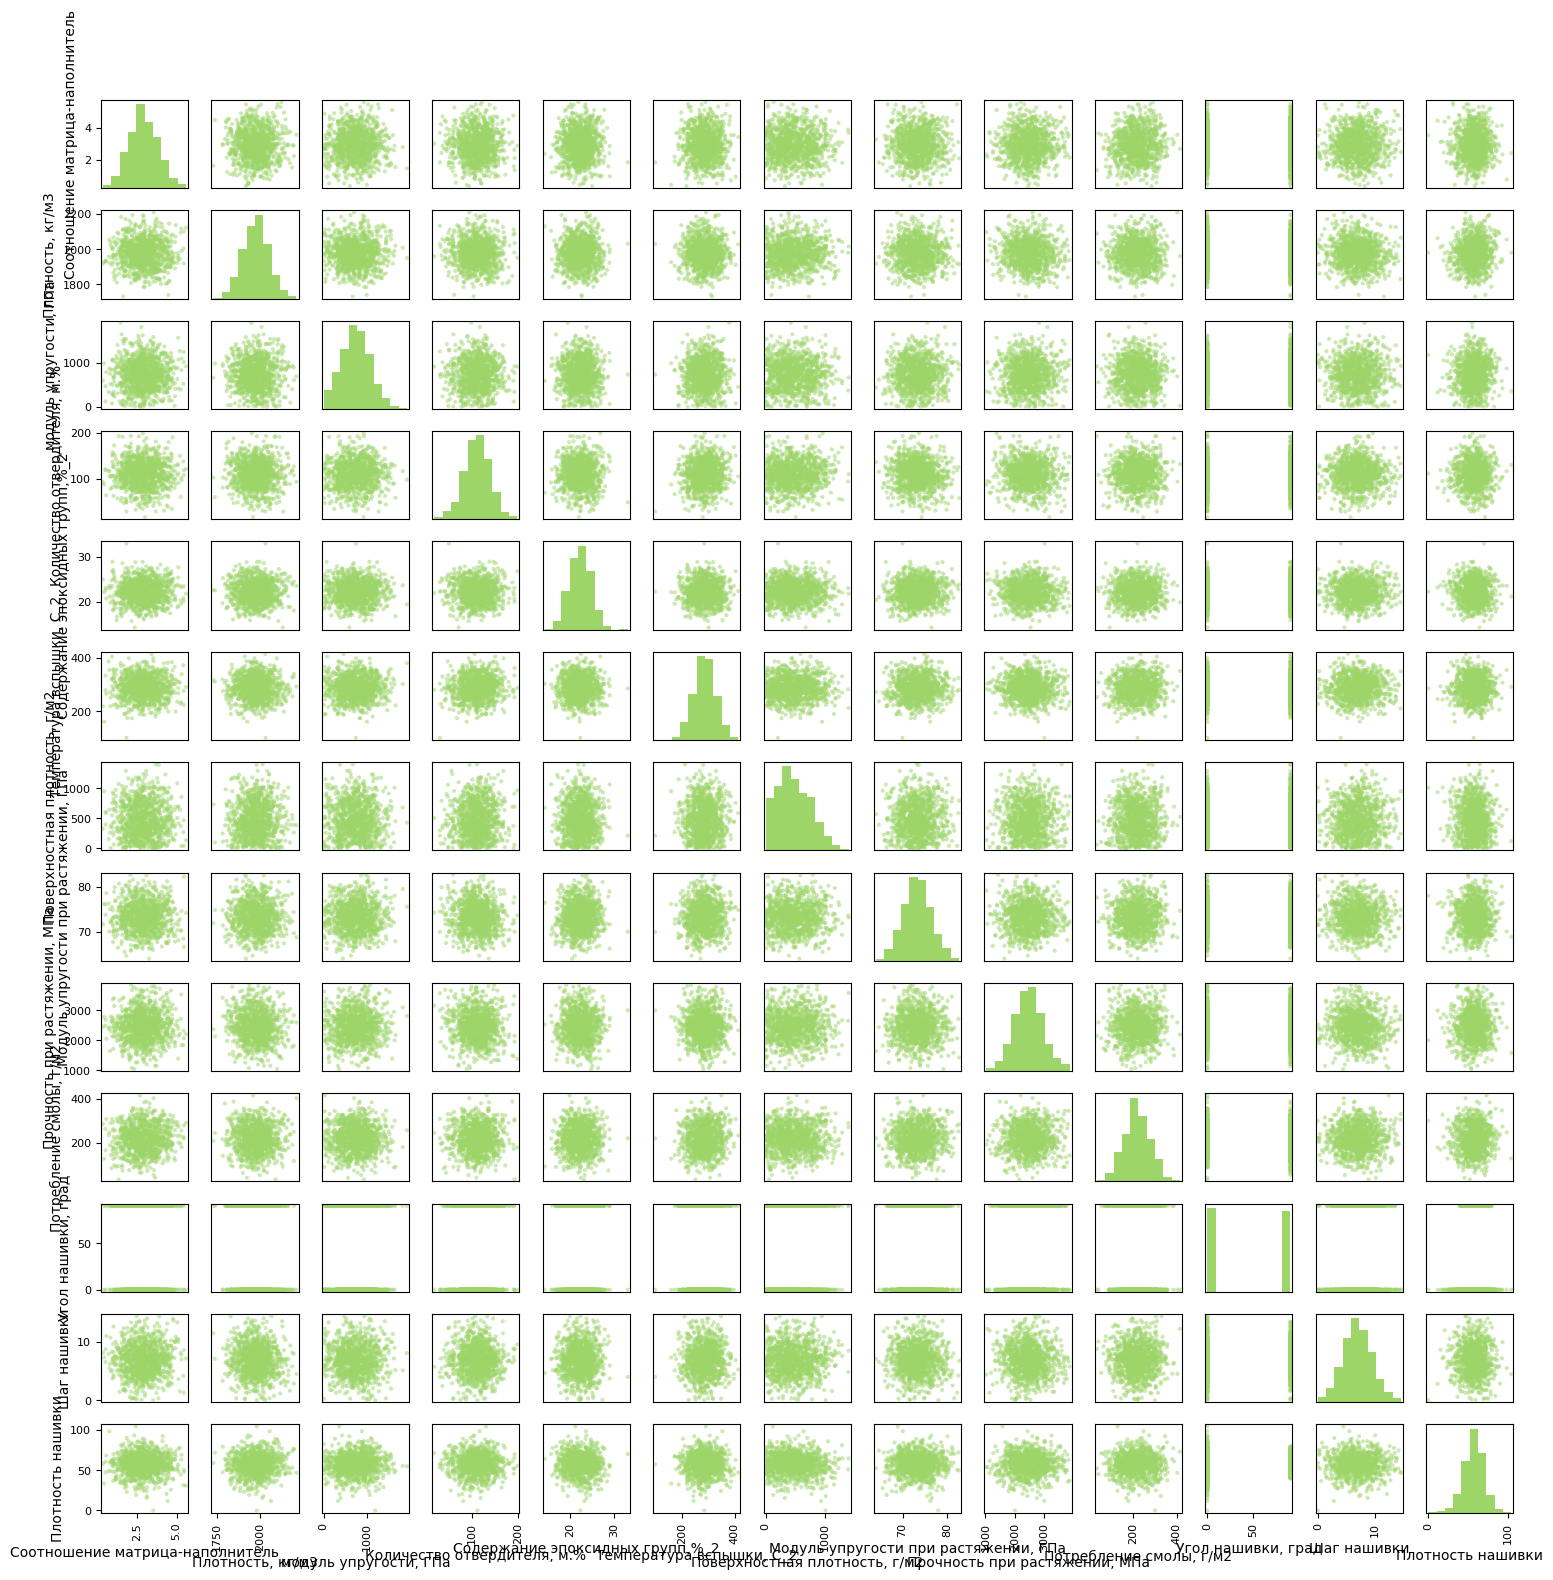

In [15]:
#numeric_data = dataset[numeric_variables]

# Создаем scatter_matrix для всех числовых переменных
scatter_matrix(dataset, figsize=(15, 15), diagonal='hist', color=selected_palette[14], hist_kwds={'color':selected_palette[14]})
plt.tight_layout()
plt.savefig('diag_ras.png')
plt.show()


#### Визуализируем отдельно данные относительно целевых переменных

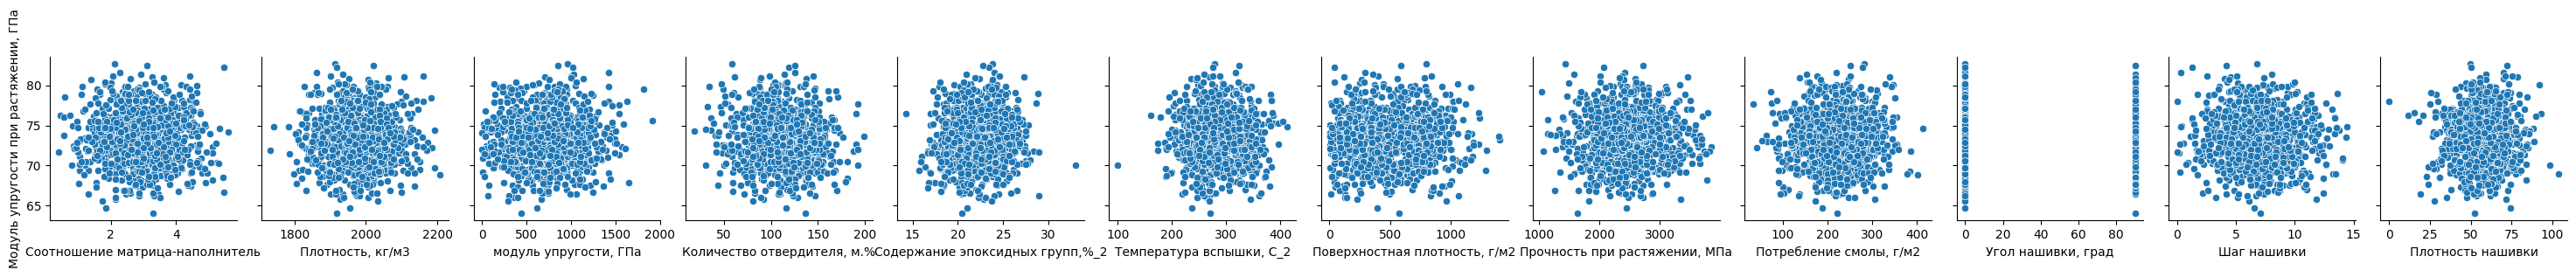

In [16]:
# все параметры относительно 'Модуль упругости при растяжении, ГПа'
sns.pairplot(dataset, x_vars=['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'], y_vars='Модуль упругости при растяжении, ГПа')
plt.show()

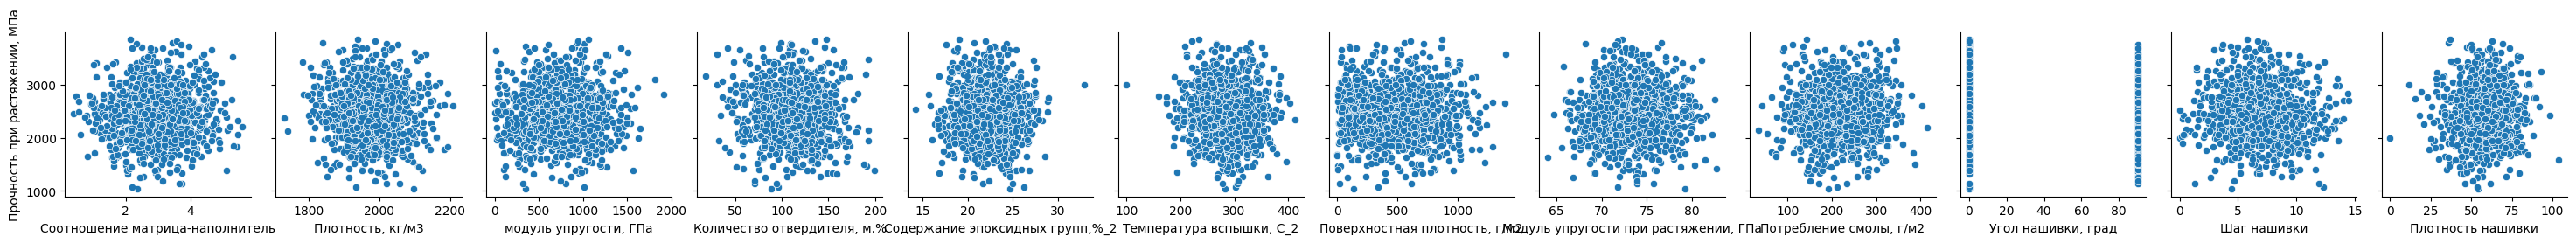

In [17]:

# все параметры относительно 'Прочность при растяжении, МПа'
sns.pairplot(dataset, x_vars=['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Потребление смолы, г/м2','Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'], y_vars='Прочность при растяжении, МПа')
plt.show()

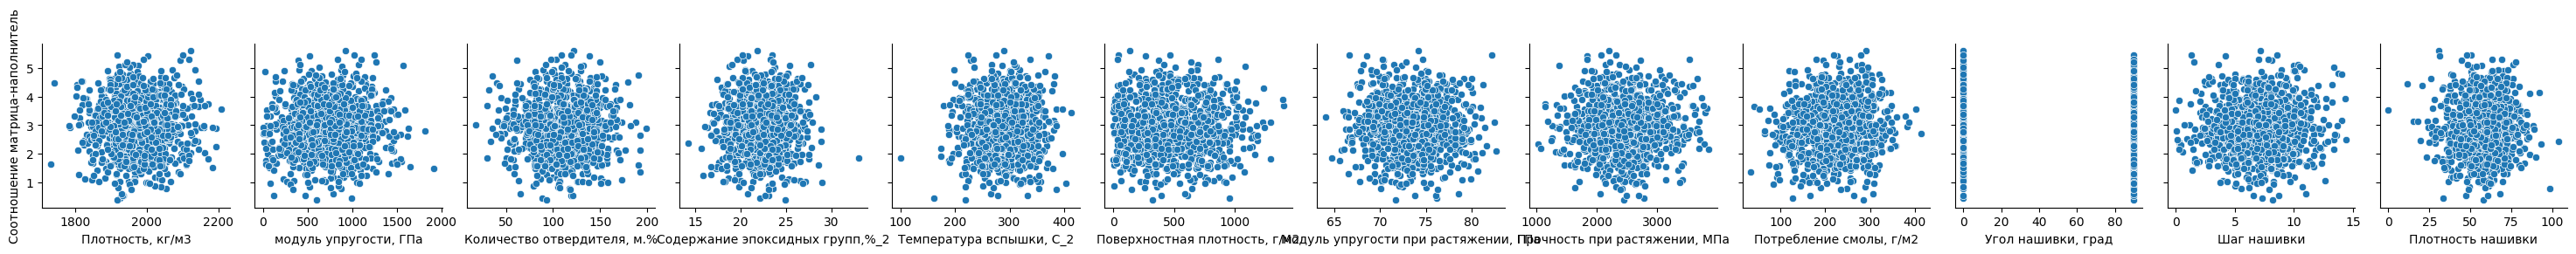

In [18]:
# все параметры относительно 'Соотношение матрица-наполнитель'
sns.pairplot(dataset, x_vars=['Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'], y_vars='Соотношение матрица-наполнитель')
plt.show()

#### Матрица коррелиции

<AxesSubplot:>

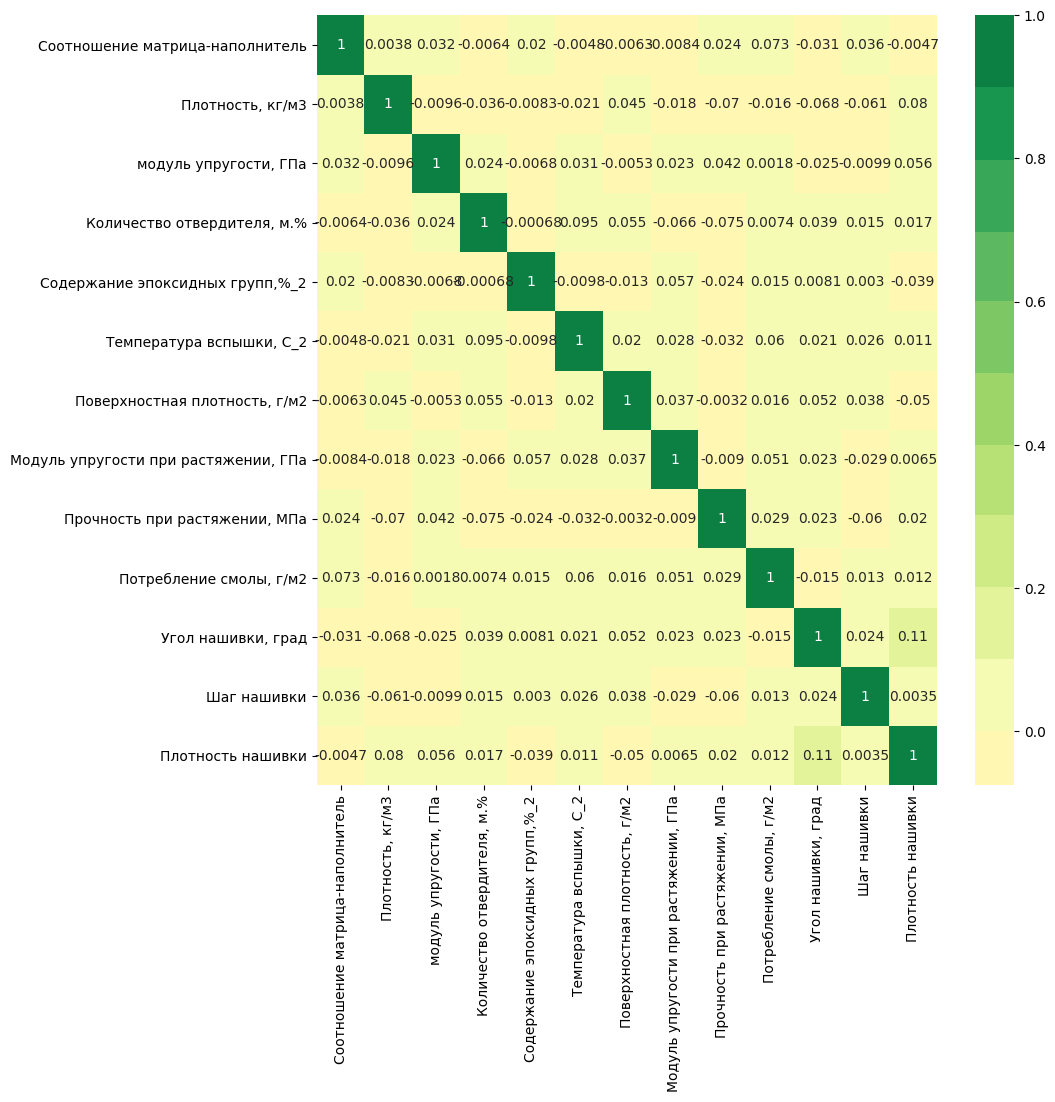

In [19]:
corr = dataset.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap=selected_palette,center=0)

Делаю вывод, что корреляция между параметрами отсутсвует

### Предобработка данных и обучение

На данном этапе я буду обучать модели для предсказания двух величин:
1. Модуль упругости при растяжении, ГПа
2. Прочность при растяжении, МПа

Обучение буду проводить на 4х алгоритмах машинного обучения
1) Linear regression 
2) Gradient boosting
3) RandomForest
4) ExtraTrees Regressor

Для оценки моделей будут использоваться метрики

MAE
MSE
R2Score

In [20]:
# создаю функцию разделения данных на обучающие и валидационные
def split_train_test(dataset, y_column):
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop(y_column, axis=1), dataset[y_column], test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [21]:
# создаю функцию для создания пайплана препроцессинга

def preprocess_data(dataset, y_column):
    # создаю трансформер для нормализации и станадризации числовых параметров
    numerical_transformer = Pipeline(steps=[('mm_scaler', MinMaxScaler()), ('st_scaler',StandardScaler()) ])
    # создаю трансформер для категоризации значений параметра Угол нашивки, т.к. их всего два вида - 0 и 90
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, dataset.drop(['Угол нашивки, град_0','Угол нашивки, град_90', y_column], axis=1).columns),
            ('cat', categorical_transformer, ['Угол нашивки, град_0','Угол нашивки, град_90']),
        ])
    return preprocessor

Отрисую гистограммы параметров датасета после предобработки.

In [3]:
## преобразую колонку Угол нашивки в две колонки
dataset = pd.get_dummies(dataset, columns=['Угол нашивки, град'], dtype=int)

In [4]:
numerical_transformer = Pipeline(steps=[('st_scaler',StandardScaler()), ('mm_scaler', MinMaxScaler()) ])
# создаю трансформер для категоризации значений параметра Угол нашивки, т.к. их всего два вида - 0 и 90
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, dataset.columns),
    ])

dataset_processed = preprocessor.fit_transform(dataset)

In [5]:
dataset_processed = pd.DataFrame(dataset_processed, columns=['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Шаг нашивки', 'Плотность нашивки', 'Угол нашивки, град_0',
       'Угол нашивки, град_90'])

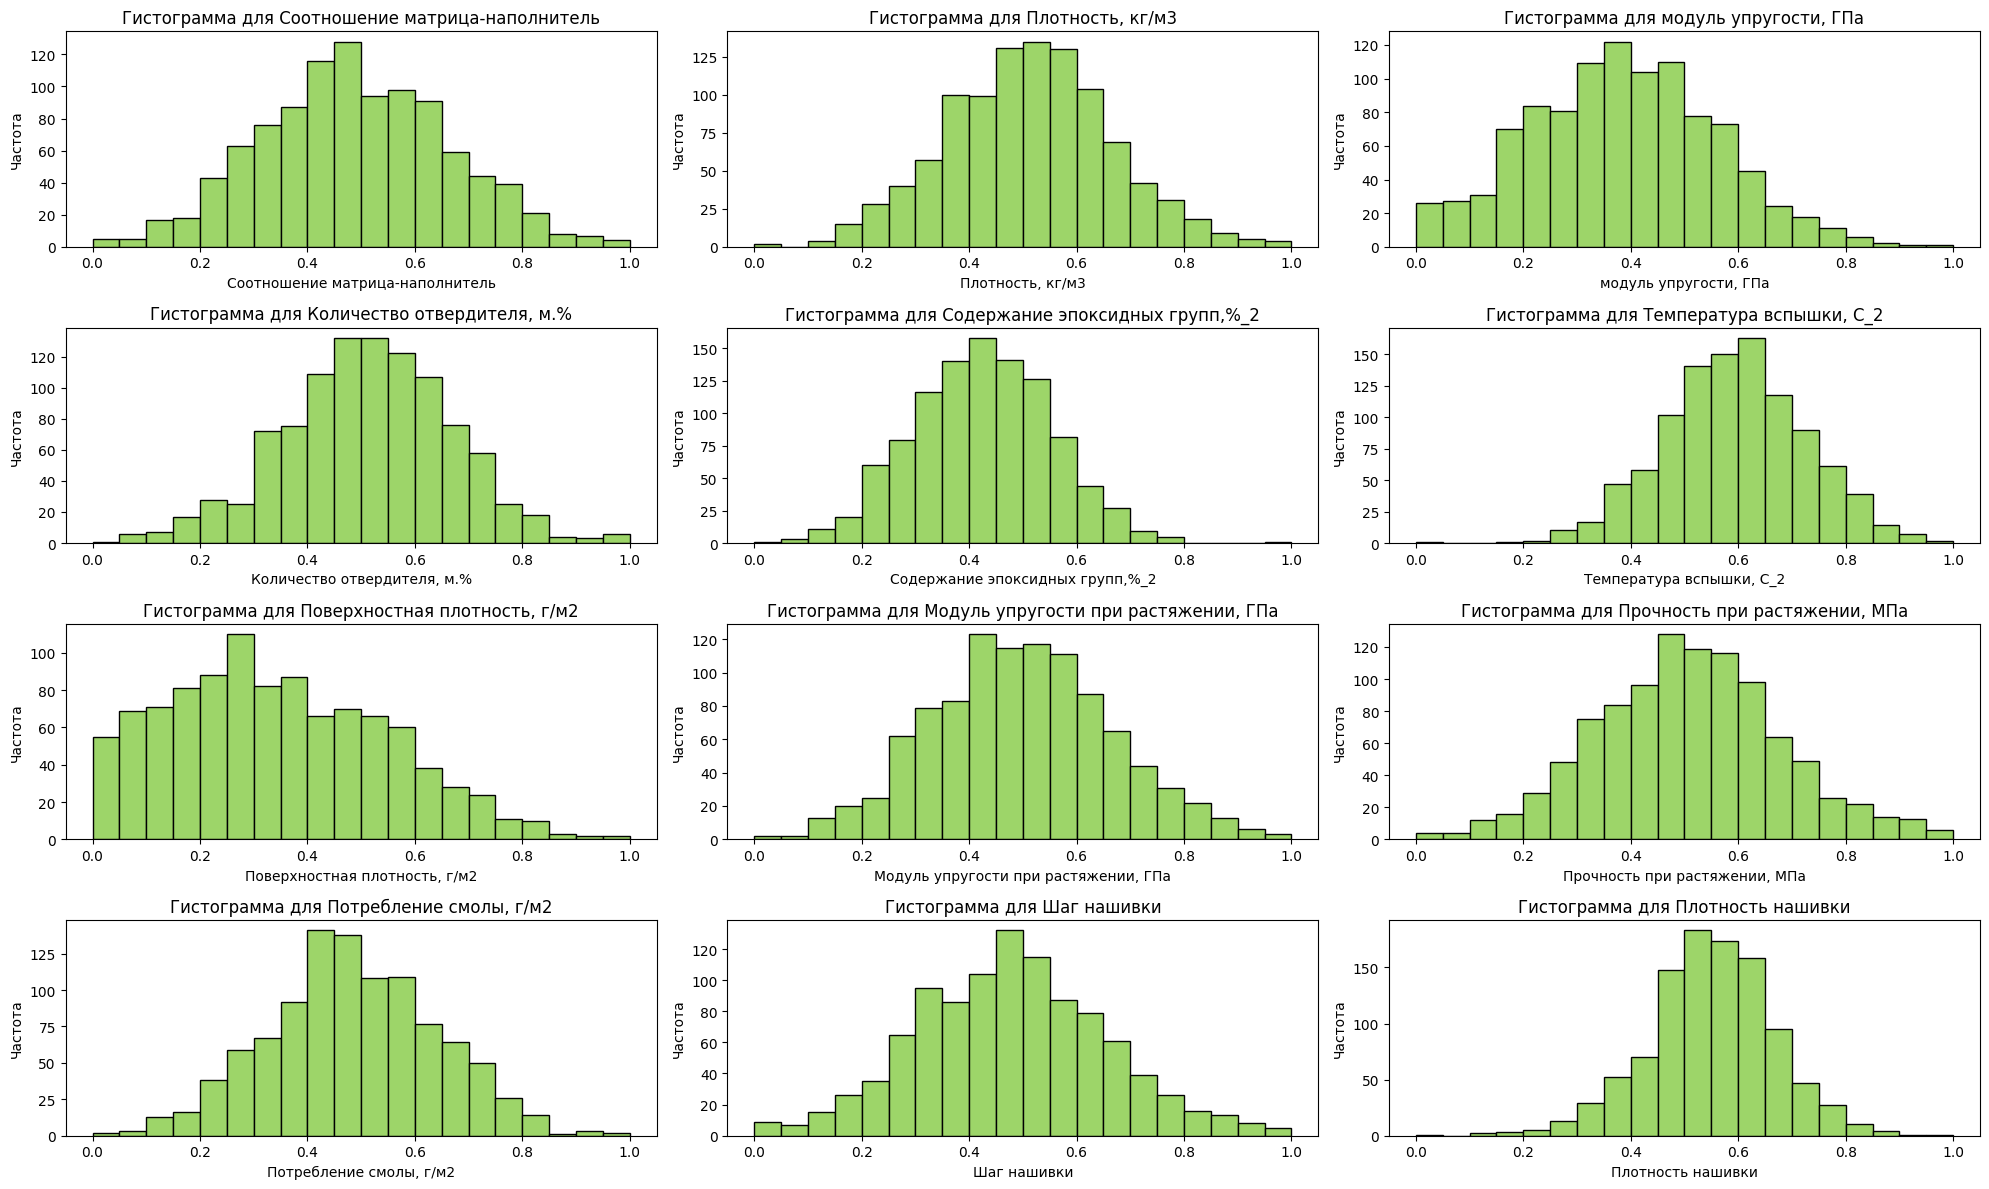

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 12))
flattened_axes = axes.flatten()

# Проходим по каждому столбцу из numeric_variables и создаем гистограмму
for i, column in enumerate(dataset_processed.drop(['Угол нашивки, град_0','Угол нашивки, град_90'], axis=1).columns):
    flattened_axes[i].hist(dataset_processed[column], bins=20, color=selected_palette[14], edgecolor='black')
    flattened_axes[i].set_title(f"Гистограмма для {column}")
    flattened_axes[i].set_xlabel(column)
    flattened_axes[i].set_ylabel("Частота")

# Отключаем неиспользуемые оси
for j in range(len(dataset_processed.drop(['Угол нашивки, град_0','Угол нашивки, град_90'], axis=1).columns), len(flattened_axes)):
    flattened_axes[j].axis('off')

plt.tight_layout()
plt.show()

In [29]:
# задаю функцию для обучения модели
def train_model(model, dataset, y_column):
    regressor = Pipeline(steps=[('preprocessor', preprocess_data(dataset, y_column)), ('model', model)])
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (MAE, MSE, r2)

In [46]:
# инициализирую модели
lr_model = LinearRegression()
gb_model = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, loss='absolute_error', random_state=0)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
et_model = ExtraTreesRegressor(n_estimators=100, random_state=0)
kn_model = KNeighborsRegressor(n_neighbors=1)
svm_model = svm.SVR(kernel="rbf", C=200, gamma=0.1, epsilon=0.1)
dt_model = tree.DecisionTreeRegressor()
ab_model= AdaBoostRegressor(estimator=et_model, random_state=0, n_estimators=100)

ml_models = (lr_model, gb_model, rf_model, et_model, kn_model, svm_model, dt_model, ab_model)

#### Обучаю алгоритмы на нахождение параметров "Модуль упругости при растяжении, ГПа" и "Прочность при растяжении, МПа"

In [31]:
y_columns = ("Модуль упругости при растяжении, ГПа", "Прочность при растяжении, МПа")

metrics = []
for y_column in y_columns:
    print("-------- Для искомого значения y - ", y_column, " ------------")
    X_train, X_test, y_train, y_test = split_train_test(dataset, y_column)
    for model in ml_models:
        MAE, MSE, r2 = train_model(model, dataset, y_column)
        metrics.append({'Искомое значений': y_column, 'Модель': type(model).__name__,"MAE": MAE, "MSE": MSE, "R2": r2})
        #print("Метрики обучения модели ", type(model).__name__, ": ", "MAE: ", MAE, "MSE: ", MSE, "R2: ", r2)
metrics = pd.DataFrame(metrics)
metrics

-------- Для искомого значения y -  Модуль упругости при растяжении, ГПа  ------------
-------- Для искомого значения y -  Прочность при растяжении, МПа  ------------


,Искомое значений,Модель,MAE,MSE,R2
0,"Модуль упругости при растяжении, ГПа",LinearRegression,2.558147,10.122306,-0.018912
1,"Модуль упругости при растяжении, ГПа",GradientBoostingRegressor,2.558167,10.063603,-0.013003
2,"Модуль упругости при растяжении, ГПа",RandomForestRegressor,2.630612,10.666786,-0.073720
3,"Модуль упругости при растяжении, ГПа",ExtraTreesRegressor,2.624597,10.702585,-0.077323
4,"Модуль упругости при растяжении, ГПа",KNeighborsRegressor,3.522315,20.266344,-1.040012
5,"Модуль упругости при растяжении, ГПа",SVR,3.641899,20.544925,-1.068054
6,"Модуль упругости при растяжении, ГПа",DecisionTreeRegressor,3.630307,20.292674,-1.042663
7,"Модуль упругости при растяжении, ГПа",AdaBoostRegressor,2.627980,10.713146,-0.078386
8,"Прочность при растяжении, МПа",LinearRegression,379.785417,222990.583201,0.004230
9,"Прочность при растяжении, МПа",GradientBoostingRegressor,378.841442,222183.073311,0.007836


#### Использую технику Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise (SMOGN) для синтетического увеличения кол-ва образцов

In [32]:
# делаю функцию для создания smogn-датасета
def smogn_aug (dataset, y_column):
    smogn_dataset = smogn.smoter(
        data = dataset, 
        y = "Модуль упругости при растяжении, ГПа",
        k = 7,
        samp_method = 'extreme',
        pert = 0.04,
        rel_method = 'auto',
        rel_xtrm_type = 'high',
    )
    return smogn_dataset

In [33]:
%%capture --no-stdout

#обучаю те же самые модели на увеличенном датасете
y_columns = ("Модуль упругости при растяжении, ГПа", "Прочность при растяжении, МПа")
metrics = []
for y_column in y_columns:
    print("-------- Для искомого значения y - ", y_column, " ------------")
    X_train, X_test, y_train, y_test = split_train_test(dataset, y_column)
    smogn_dataset = smogn_aug(dataset, y_column)
    print("Размер датасета до увеличения: ", dataset.shape, " после: ", smogn_dataset.shape)
    for model in ml_models:
        MAE, MSE, r2 = train_model(model, smogn_dataset, y_column)
        #print("Метрики обучения модели ", type(model).__name__, ": ", "MAE: ", MAE, "MSE: ", MSE, "R2: ", r2)
        metrics.append({'Искомое значений': y_column, 'Модель': type(model).__name__,"MAE": MAE, "MSE": MSE, "R2": r2})
metrics = pd.DataFrame(metrics)
metrics

-------- Для искомого значения y -  Модуль упругости при растяжении, ГПа  ------------
Размер датасета до увеличения:  (1023, 14)  после:  (1747, 14)
-------- Для искомого значения y -  Прочность при растяжении, МПа  ------------
Размер датасета до увеличения:  (1023, 14)  после:  (1747, 14)


In [34]:
metrics

,Искомое значений,Модель,MAE,MSE,R2
0,"Модуль упругости при растяжении, ГПа",LinearRegression,2.558147,10.122306,-0.018912
1,"Модуль упругости при растяжении, ГПа",GradientBoostingRegressor,2.558167,10.063603,-0.013003
2,"Модуль упругости при растяжении, ГПа",RandomForestRegressor,2.630612,10.666786,-0.073720
3,"Модуль упругости при растяжении, ГПа",ExtraTreesRegressor,2.624597,10.702585,-0.077323
4,"Модуль упругости при растяжении, ГПа",KNeighborsRegressor,3.522315,20.266344,-1.040012
5,"Модуль упругости при растяжении, ГПа",SVR,3.641899,20.544925,-1.068054
6,"Модуль упругости при растяжении, ГПа",DecisionTreeRegressor,3.816654,22.386945,-1.253472
7,"Модуль упругости при растяжении, ГПа",AdaBoostRegressor,2.627980,10.713146,-0.078386
8,"Прочность при растяжении, МПа",LinearRegression,379.785417,222990.583201,0.004230
9,"Прочность при растяжении, МПа",GradientBoostingRegressor,378.841442,222183.073311,0.007836


#### Использую VotingRegressor для голосования между всеми ранее использованными алгоритмами

In [35]:
from sklearn.ensemble import VotingRegressor

In [36]:
%%capture --no-stdout

y_columns = ("Модуль упругости при растяжении, ГПа", "Прочность при растяжении, МПа")

vote_model = VotingRegressor([('lr_model', lr_model), ('gb_model', gb_model), ('rf_model', rf_model), ('et_model', et_model), ('kn_model', kn_model), 
                              ('svm_model', svm_model), ('dt_model', dt_model), ('ab_model', ab_model)])
metrics = []
for y_column in y_columns:
    print("-------- Для искомого значения y - ", y_column, " ------------")
    X_train, X_test, y_train, y_test = split_train_test(smogn_dataset, y_column)
    MAE, MSE, r2 = train_model(vote_model, smogn_dataset, y_column)
    #print("Метрики обучения модели ", type(vote_model).__name__, ": ", "MAE: ", MAE, "MSE: ", MSE, "R2: ", r2)
    metrics.append({'Искомое значений': y_column, 'Модель': type(vote_model).__name__,"MAE": MAE, "MSE": MSE, "R2": r2})
metrics = pd.DataFrame(metrics)
metrics

-------- Для искомого значения y -  Модуль упругости при растяжении, ГПа  ------------
-------- Для искомого значения y -  Прочность при растяжении, МПа  ------------


In [37]:
metrics

,Искомое значений,Модель,MAE,MSE,R2
0,"Модуль упругости при растяжении, ГПа",VotingRegressor,1.903537,9.649224,0.516697
1,"Прочность при растяжении, МПа",VotingRegressor,287.062996,160715.023040,0.341588


#### Использую стекинг для объединения используемых раннее алгоритмов, в качестве финального - Random Forest Regressor

In [38]:
estimators = [
   ('lr_model', lr_model), ('gb_model', gb_model), ('rf_model', rf_model), ('et_model', et_model), ('kn_model', kn_model), 
                              ('svm_model', svm_model), ('dt_model', dt_model), ('ab_model', ab_model)
]
stack = StackingRegressor(estimators=estimators,
                          final_estimator=RandomForestRegressor(n_estimators=10,
                                                                random_state=42))

metrics = []
for y_column in y_columns:
    print("-------- Для искомого значения y - ", y_column, " ------------")
    X_train, X_test, y_train, y_test = split_train_test(smogn_dataset, y_column)
    MAE, MSE, r2 = train_model(stack, smogn_dataset, y_column)
    #print("Метрики обучения модели ", type(stack).__name__, ": ", "MAE: ", MAE, "MSE: ", MSE, "R2: ", r2)
    metrics.append({'Искомое значений': y_column, 'Модель': type(stack).__name__,"MAE": MAE, "MSE": MSE, "R2": r2})
metrics = pd.DataFrame(metrics)
metrics

-------- Для искомого значения y -  Модуль упругости при растяжении, ГПа  ------------
-------- Для искомого значения y -  Прочность при растяжении, МПа  ------------


,Искомое значений,Модель,MAE,MSE,R2
0,"Модуль упругости при растяжении, ГПа",StackingRegressor,1.588542,7.513529,0.623668
1,"Прочность при растяжении, МПа",StackingRegressor,256.158718,163481.786993,0.330253


### Обучение НС

### Pytorch

In [3]:
data_1 = pd.read_excel('./dataset/X_bp.xlsx', index_col=0)
data_2 = pd.read_excel('./dataset/X_nup.xlsx', index_col=0)

dataset = data_1.join(data_2, how='inner')

## преобразую колонку Угол нашивки в две колонки
dataset = pd.get_dummies(dataset, columns=['Угол нашивки, град'], dtype=int) 


train_df, test_df = train_test_split(dataset.astype(np.float32), test_size=0.3, random_state=42, shuffle=True)


In [4]:
transformer_train = Pipeline(steps=[('st_scaler',StandardScaler()), ('mm_scaler', MinMaxScaler()) ])
transformer_test = Pipeline(steps=[('st_scaler',StandardScaler()), ('mm_scaler', MinMaxScaler()) ])

preprocessor_train = transformer_train.fit(train_df)
preprocessor_test = transformer_test.fit(test_df)

In [5]:
train_df_transformed = preprocessor_train.transform(train_df)
test_df_transformed = preprocessor_test.transform(test_df)

In [6]:
train_df_transformed = pd.DataFrame(train_df_transformed, columns=train_df.columns)
test_df_transformed =  pd.DataFrame(test_df_transformed, columns=test_df.columns)

In [7]:
# создаю класс для создания датасета для загрузки в модель
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy()
        features = row[1:]
        label = row[0]
        return features, label

    def __len__(self):
        return len(self.dataframe)

In [8]:
cd_train_df = CustomDataset(dataframe=train_df_transformed)
cd_test_df = CustomDataset(dataframe=test_df_transformed)

In [9]:
# создаю архитектуру сети с двумя скрытыми слоями и 100 нейронами на каждом скрытом слое
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
#        self.hidden = torch.nn.Linear(n_hidden, n_output)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

net = Net(n_feature=13, n_hidden=100, n_output=1)
print(net)

Net(
  (hidden): Linear(in_features=13, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
)


In [9]:
# # из нормализованного датасета делаем разделение на обучаемые и тестовые данные
# train_df, test_df = train_test_split(dataset.astype(np.float32), test_size=0.2, shuffle=True)

# cd_train_df = CustomDataset(dataframe=train_df)
# cd_test_df = CustomDataset(dataframe=test_df)

In [10]:
loss_func = torch.nn.MSELoss()

BATCH_SIZE = 64
EPOCH = 150


# определяем, какими кусочками будем загружать данные
loader_train = Data.DataLoader(
    dataset = cd_train_df,
    batch_size = BATCH_SIZE,
    shuffle = True, num_workers = 0,
)

loader_test = Data.DataLoader(
    dataset = cd_test_df,
    batch_size = len(cd_test_df),
    shuffle = True, num_workers = 0,
)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [11]:
# 100 раз проходимся по данным - обучаем 
final_losses = []
for epoch in range (EPOCH):
    print(f'Starting epoch {epoch+1}')
    for _,(test_x, test_y) in enumerate(loader_test):
        for step, (batch_x, batch_y) in enumerate(loader_train):
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            # шаги обучения
            prediction = net(b_x).reshape(1,-1)[0]  # делаем предсказания
            #prediction = net(torch.tensor(np.array(b_x).reshape(1,-1)))
            loss = loss_func(prediction, b_y) # считаем функцию потерб для предсказания
    
            prediction = net(test_x).reshape(1,-1)[0]
    
            loss = loss_func(test_y, prediction)
    
            optimizer.zero_grad() # обнуляем градиенты, чтобы обучение происходило
            loss.backward() # расчитываем ошибку, т.е. делаем обратный проход
            optimizer.step() # шаг в сторону оптимизации
                  # Print statistics
            #current_loss += loss.item()
    
            
            MAE = mean_absolute_error(test_y.detach().numpy(), prediction.detach().numpy())
            MSE = mean_squared_error(test_y.detach().numpy(), prediction.detach().numpy())
            r2 = r2_score(test_y.detach().numpy(), prediction.detach().numpy())
        final_losses.append(loss.item())
        print("Epoch number: {} and the loss: {}".format(epoch+1, loss.item()))
        print('MAE: ', MAE, 'MSE: ', MSE, 'r2: ', r2)

Starting epoch 1
Epoch number: 1 and the loss: 0.05432340130209923
MAE:  0.18852794 MSE:  0.0543234 r2:  -0.5812499318432602
Starting epoch 2
Epoch number: 2 and the loss: 0.03480631858110428
MAE:  0.15158242 MSE:  0.03480632 r2:  -0.013145150565852859
Starting epoch 3
Epoch number: 3 and the loss: 0.034889958798885345
MAE:  0.15237801 MSE:  0.03488996 r2:  -0.015579775166674192
Starting epoch 4
Epoch number: 4 and the loss: 0.03446365147829056
MAE:  0.150955 MSE:  0.034463648 r2:  -0.0031706402029840763
Starting epoch 5
Epoch number: 5 and the loss: 0.03389282152056694
MAE:  0.14973216 MSE:  0.03389283 r2:  0.013444974639141072
Starting epoch 6
Epoch number: 6 and the loss: 0.033680204302072525
MAE:  0.14931907 MSE:  0.033680208 r2:  0.01963386356486374
Starting epoch 7
Epoch number: 7 and the loss: 0.03342417627573013
MAE:  0.14868908 MSE:  0.03342418 r2:  0.027086337342038913
Starting epoch 8
Epoch number: 8 and the loss: 0.03320993855595589
MAE:  0.14809276 MSE:  0.03320994 r2:  0.

In [12]:
print('В результате обучения нейронной сети  pytorch получаю следующие результаты модели:')
print('MAE: ', MAE, 'MSE: ', MSE, 'r2: ', r2)

В результате обучения нейронной сети  pytorch получаю следующие результаты модели:
MAE:  0.0543464 MSE:  0.005176722 r2:  0.8493155583784425


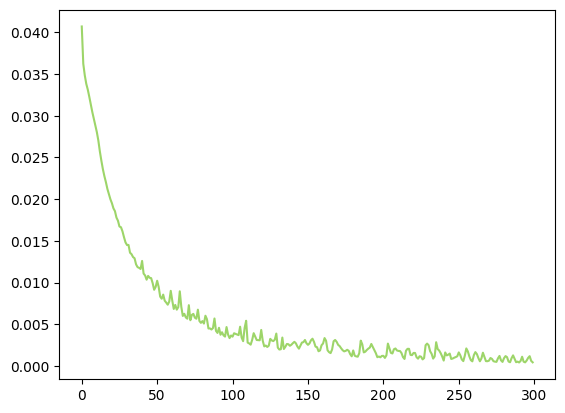

In [13]:
## отрисую график уменьшения loss за 100 эпох обучения
plt.plot(final_losses, color=selected_palette[14])
plt.show()

In [1387]:
# Saving model
model_scripted = torch.jit.script(net) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

# Loading model
#model = torch.jit.load('model_scripted.pt')
#model.eval()

In [50]:
loaded_model = torch.load('torch_model.pt')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/serialization.py:602: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [184]:
preprocessed = preprocessor_train.transform((np.array([1900, 700, 152, 22, 235, 143, 68, 2434, 265, 5, 55, 1, 0]).reshape(1,-1).astype('float32')))
y_pred_raw = loaded_model(torch.tensor(preprocessed))
y_pred = preprocessor_test.inverse_transform(y_pred_raw.detach().numpy())
y_pred.item()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


3.1384739875793457

### TensorFlow

In [2]:
data_1 = pd.read_excel('./dataset/X_bp.xlsx', index_col=0)
data_2 = pd.read_excel('./dataset/X_nup.xlsx', index_col=0)

dataset = data_1.join(data_2, how='inner')

## преобразую колонку Угол нашивки в две колонки
dataset = pd.get_dummies(dataset, columns=['Угол нашивки, град'], dtype=int) 

In [3]:
# делаю функцию для создания smogn-датасета
def smogn_aug (dataset, y_column):
    smogn_dataset = smogn.smoter(
        data = dataset, 
        y = "Модуль упругости при растяжении, ГПа",
        k = 7,
        samp_method = 'extreme',
        pert = 0.04,
        rel_method = 'auto',
        rel_xtrm_type = 'high',
    )
    return smogn_dataset

smogn_dataset = smogn_aug(dataset, 'Соотношение матрица-наполнитель')

synth_matrix: 100%|###########################| 102/102 [00:01<00:00, 58.58it/s]


In [4]:
# из увеличенного датасета делаем разделение на обучаемые и тестовые данные
train_df, test_df = train_test_split(smogn_dataset.astype(np.float32), test_size=0.2, shuffle=True)

In [5]:
train_data = train_df.drop(['Соотношение матрица-наполнитель'], axis=1)
train_targets = train_df['Соотношение матрица-наполнитель']

test_data = test_df.drop(['Соотношение матрица-наполнитель'], axis=1)
test_targets = test_df['Соотношение матрица-наполнитель']

In [6]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(np.array(train_data))

2025-03-26 20:24:11.333892: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def build_model():
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(100, activation="relu", input_shape=(13,)))
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [8]:
# k-fold
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores_mae = []
all_scores_mse = []


for i in range(k):
    print('Processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partitial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]], axis=0
    )
    partitial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], axis=0
    )
    model = build_model()

    model.fit(partitial_train_data, partitial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores_mae.append(val_mae)
    all_scores_mse.append(val_mse)
    test_preds = model.predict(test_data)
    MAE = mean_absolute_error(test_targets, test_preds)
    MSE = mean_squared_error(test_targets, test_preds)
    r2 = r2_score(np.array(test_targets), test_preds.reshape(1,-1)[0])
    print('MAE: ', MAE, 'MSE: ', MSE, 'r2: ', r2)
        

Processing fold # 0
MAE:  0.52161723 MSE:  0.5900141 r2:  0.2313895448880272
Processing fold # 1
MAE:  0.540163 MSE:  0.6049906 r2:  0.21187971693475605
Processing fold # 2
MAE:  0.540548 MSE:  0.6052387 r2:  0.21155658040265224
Processing fold # 3
MAE:  0.50730515 MSE:  0.57906604 r2:  0.24565162089857384


In [185]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 13)               27        
 ion)                                                            
                                                                 
 dense_14 (Dense)            (None, 100)               1400      
                                                                 
 dense_15 (Dense)            (None, 100)               10100     
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 11,628
Trainable params: 11,601
Non-trainable params: 27
_________________________________________________________________


In [9]:
history = model.fit(train_data, train_targets, epochs=150, batch_size=1, verbose=1)

Epoch 1/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.2314 - mae: 0.3181
Epoch 2/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.1385 - mae: 0.2483
Epoch 3/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.1154 - mae: 0.2265
Epoch 4/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0956 - mae: 0.2163
Epoch 5/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0934 - mae: 0.2141
Epoch 6/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0782 - mae: 0.1949
Epoch 7/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0753 - mae: 0.1975
Epoch 8/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0707 - mae: 0.1951
Epoch 9/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0612 - mae: 0.1804
Epoch 10/150
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0601 - mae: 0.1806
Epoch 11/150
1397/1

In [11]:
test_preds = model.predict(test_data)

MAE = mean_absolute_error(test_targets, test_preds)
MSE = mean_squared_error(test_targets, test_preds)
r2 = r2_score(np.array(test_targets), test_preds.reshape(1,-1)[0])
print('В результате обучения нейронной сети tensorflow получаю следующие результаты модели:')
print('MAE: ', MAE, 'MSE: ', MSE, 'r2: ', r2)

В результате обучения нейронной сети tensorflow получаю следующие результаты модели:
MAE:  0.5019785 MSE:  0.58871514 r2:  0.23308178868918294


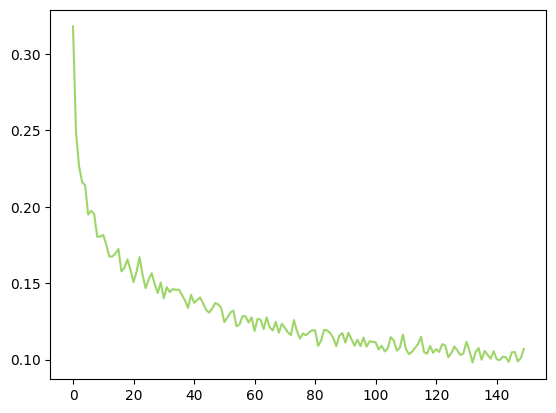

In [14]:
## отрисую график уменьшения loss за 100 эпох обучения
plt.plot(history.history['mae'], color=selected_palette[14])
plt.show()

In [60]:
model.save('tf_model.tf')

2025-03-22 16:37:35.552276: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tf_model.tf/assets


In [27]:
tf_model = tf.keras.models.load_model('tf_model.tf')

In [45]:
tf_model.predict(np.array([1900, 700, 152, 22, 235, 143, 68, 2434, 265, 5, 55, 1, 0]).reshape(1,-1))

array([[4.1330323]], dtype=float32)